In [1]:
from typing import List
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Change which dataset to use!

image_folders: List[str] = [
    "./dataset/",
    "./dataset_automatic/",
    "./dataset_bad_corrected/"
]

data: DataFrame = DataFrame(columns=['filename', 'filepath', 'label', 'char1', 'char2', 'char3', 'char4', 'char5'])

i = 0
for img_folder in image_folders:
    for _, _, files in os.walk(img_folder):
        for f in files:
            data.loc[i, 'filename'] = f
            data.loc[i, 'filepath'] = os.path.join(img_folder, f)
            filename_without_extension: str = f.split('.')[0]
            data.loc[i, 'label'] = filename_without_extension
            data.loc[i, 'char1'] = filename_without_extension[0]
            data.loc[i, 'char2'] = filename_without_extension[1]
            data.loc[i, 'char3'] = filename_without_extension[2]
            data.loc[i, 'char4'] = filename_without_extension[3]
            data.loc[i, 'char5'] = filename_without_extension[4]
            i += 1
del i

print(data.describe())

         filename             filepath  label  char1  char2  char3  char4  \
count       41147                41147  41147  41147  41147  41147  41147   
unique      41130                41147  41130     20     20     20     20   
top     n4834.png  ./dataset/22c6p.png  n4834      n      n      n      n   
freq            2                    1      2   4026   3899   3856   3888   

        char5  
count   41147  
unique     20  
top         n  
freq     4016  


A quick overview of the dataset:
- The dataset contains 1000 files.
- Each file is an image representing a CAPTCHA image.
- The file name is composed of the 5 characters contained in the CAPTCHA image followed by the image format.

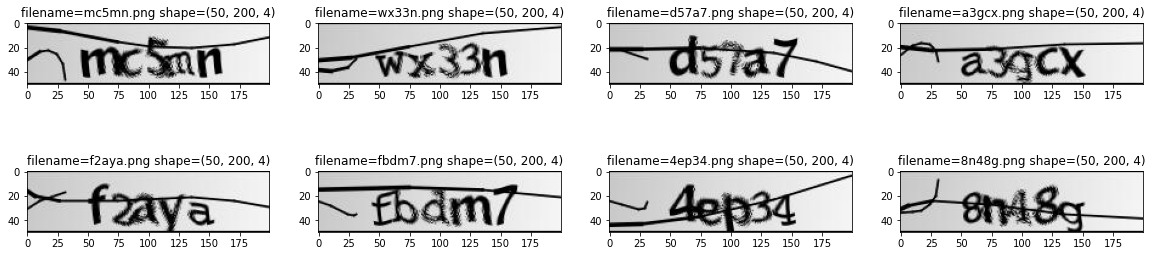

In [2]:
from image_loading import offset

samples = {
    captcha['filename']: mpimg.imread(captcha['filepath'])[:, offset:-offset]
    for index, captcha
    in data.sample(8).iterrows()
}

fig = plt.figure(figsize=(20, 5))
pos = 1
for filename, img in samples.items():
    fig.add_subplot(2, 4, pos)
    plt.imshow(img)
    plt.title('filename=' + filename + ' shape=' + str(img.shape))
    pos += 1
plt.show()

Each image us 50x200 pixels.

Now, looking at the characters in the CAPTCHA images, one can notice that:
- only 20 characters are used 2,3,4,5,6,7,8 and a,b,c,d,e,f,g,m,n,p,w,x,y
- the frequency of each character is roughly the same with one exception : n is used twice often than other characters

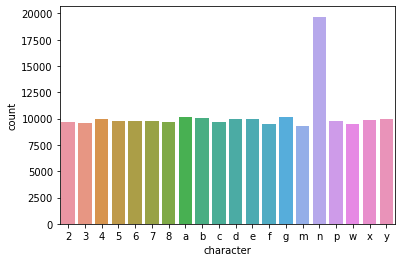

In [3]:
#df.head()

character_data = pd.DataFrame(
    data['char1'].value_counts() +
    data['char2'].value_counts() +
    data['char3'].value_counts() +
    data['char4'].value_counts() +
    data['char5'].value_counts()
).reset_index()
character_data.columns = ['character', 'count']

sns.barplot(data=character_data, x='character', y='count')
plt.show()

In [4]:
def compute_perf_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
        return np.sum(predictions == groundtruth) / (predictions.shape[0] * predictions.shape[1])
    else:
        raise Exception('Error : the size of the arrays do not match. Cannot compute the performance metric')

The training set will have 90% of the data :
- X_train with 90% images. X_train shape will be (90%,50,200,1)
- y_train with 90% labels. y_train shape will be (90%,5)

The validation set will have 10% of the data 
- X_val with 10% images. X_val shape will be (10%,50,200,1)
- y_val with 10% labels. y_val shape will be (10%,5)

The label corresponding to each image is a string corresponding to the filename minus the extension.

In [5]:
# Dictionaries that will be used to convert characters to integers and vice-versa

##############################################################################################################################
# This function encodes a single sample. 
# Inputs :
# - img_path : the string representing the image path e.g. '/kaggle/input/captcha-version-2-images/samples/samples/6n6gg.jpg'
# - label : the string representing the label e.g. '6n6gg'
# - crop : boolean, if True the image is cropped around the characters and resized to the original size.
# Outputs :
# - a multi-dimensional array reprensenting the image. Its shape is (50, 200, 1)
# - an array of integers representing the label after encoding the characters to integer. E.g [6,16,6,14,14] for '6n6gg' 
##############################################################################################################################

from image_loading import encode_single_sample, char_to_num, vocabulary


def create_train_and_validation_datasets(crop=False):
    # Loop on all the files to create X whose shape is (1000, 50, 200, 1) and y whose shape is (1000, 5)
    X, y = [], []

    for index, row in data.iterrows():
        img, label = encode_single_sample(row['filepath'], row['label'], crop)
        X.append(img)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    test_size = 0.2

    # Split X, y to get X_train, y_train, X_val, y_val 
    X_train, X_val, y_train, y_val = train_test_split(
        X.reshape(len(X), 200 * 50),
        y,
        test_size=test_size,
        shuffle=True,
        random_state=42
    )

    X_train, X_val = X_train.reshape(
        len(X_train), 200, 50, 1
    ), X_val.reshape(
        len(X_val), 200, 50, 1
    )
    return X_train, X_val, y_train, y_val

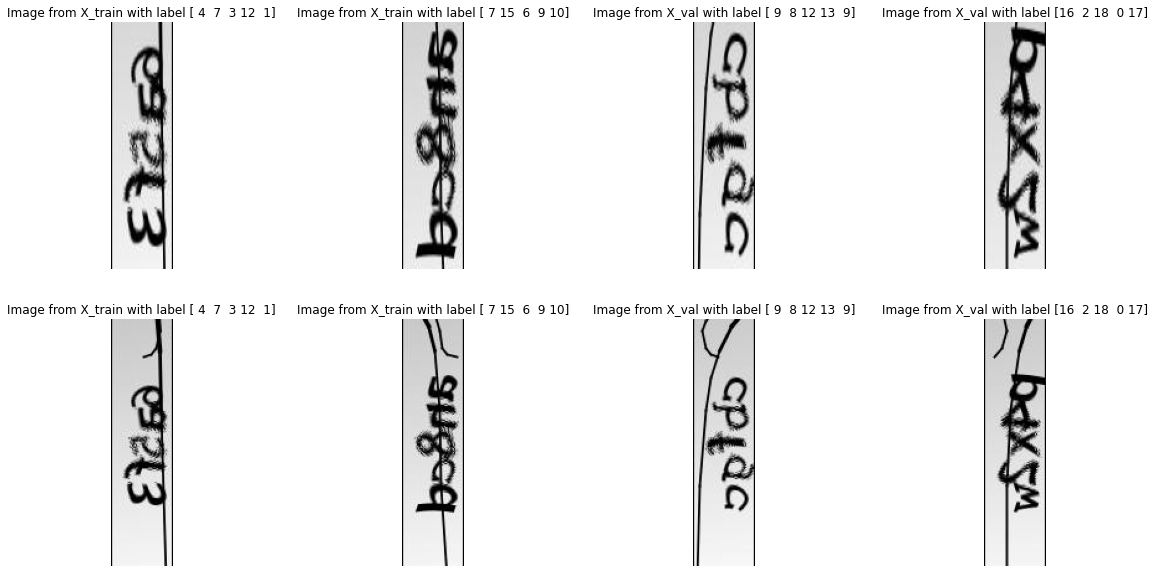

In [6]:
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=True)
X_train_, X_val_, y_train_, y_val_ = create_train_and_validation_datasets(crop=False)

fig = plt.figure(figsize=(20, 10))
fig.add_subplot(2, 4, 1)
plt.imshow(X_train[0], cmap='gray')
#plt.imshow(X_train[0].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_train with label ' + str(y_train[0]))
plt.axis('off')
fig.add_subplot(2, 4, 2)
plt.imshow(X_train[-1], cmap='gray')
#plt.imshow(X_train[-1].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_train with label ' + str(y_train[-1]))
plt.axis('off')
fig.add_subplot(2, 4, 3)
plt.imshow(X_val[0], cmap='gray')
#plt.imshow(X_val[0].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_val with label ' + str(y_val[0]))
plt.axis('off')
fig.add_subplot(2, 4, 4)
plt.imshow(X_val[-1], cmap='gray')
#plt.imshow(X_val[-1].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_val with label ' + str(y_val[-1]))
plt.axis('off')
fig.add_subplot(2, 4, 5)
plt.imshow(X_train_[0], cmap='gray')
plt.title('Image from X_train with label ' + str(y_train_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 6)
plt.imshow(X_train_[-1], cmap='gray')
plt.title('Image from X_train with label ' + str(y_train_[-1]))
plt.axis('off')
fig.add_subplot(2, 4, 7)
plt.imshow(X_val_[0], cmap='gray')
plt.title('Image from X_val with label ' + str(y_val_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 8)
plt.imshow(X_val_[-1], cmap='gray')
plt.title('Image from X_val with label ' + str(y_val_[-1]))
plt.axis('off')
plt.show()

## Build Model

In [7]:
def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(200, 50, 1), name="image", dtype="float32")

    # First conv block
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(
        input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64 --> output volume shape = (200/4,12,64)
    # Reshape to "split" the volume in 5 time-steps
    x = layers.Reshape(target_shape=(5, int((200 / 4 * 12 * 64) / 5)), name="reshape")(x)

    # FC layers
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dense(64, activation="relu", name="dense2")(x)

    # Output layer
    output = layers.Dense(len(vocabulary), activation="softmax", name="dense3")(x)

    # Define the model
    model = keras.models.Model(inputs=input_img, outputs=output, name="ocr_classifier_based_model")

    # Compile the model and return
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_classifier_based_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 5, 7680)           0         
                                                                 
 dense1 (Dense)              (None, 5, 2

## Train the model

In [8]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])

Epoch 1/100
1029/1029 [==============================] - 95s 92ms/step - loss: 0.2472 - accuracy: 0.9353 - val_loss: 0.0535 - val_accuracy: 0.9826

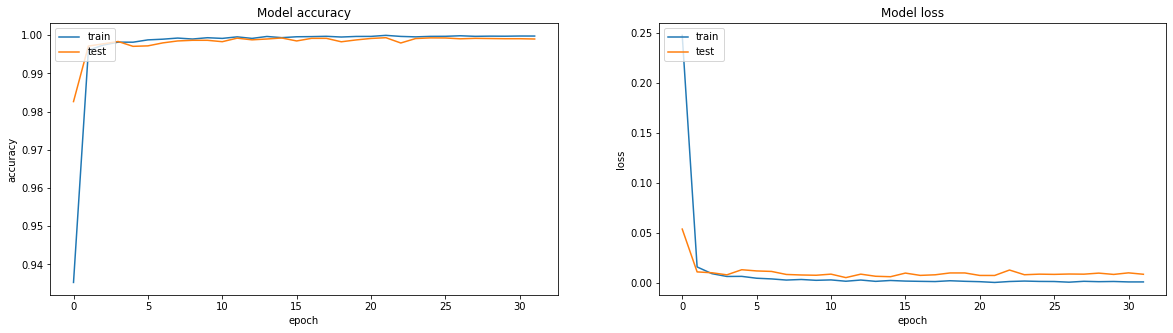

In [9]:
fig = plt.figure(figsize=(20, 5))
# summarize history for accuracy
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# plt.savefig("model_accuracy.png")
plt.show()

## Predictions

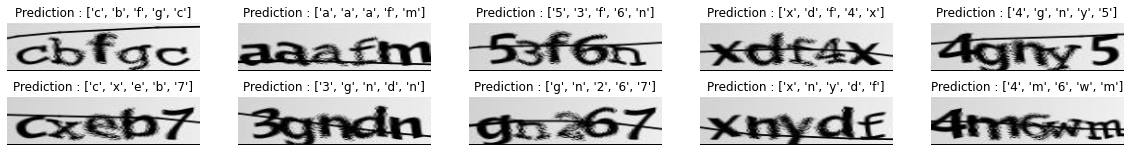

In [10]:
y_pred = model.predict(X_val)  # y_pred shape = (100,50,len(vocabulary))
y_pred = np.argmax(y_pred, axis=2)
num_to_char = {v: k for k, v in char_to_num.items()}
num_to_char[-1] = 'UKN'

nrow = 1
fig = plt.figure(figsize=(20, 5))
for i in range(0, 10):
    if i > 4: nrow = 2
    fig.add_subplot(nrow, 5, i + 1)
    plt.imshow(X_val[i].transpose((1, 0, 2)), cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x: num_to_char[x], y_pred[i]))))
    plt.axis('off')
plt.show()

## Model Performance

In [13]:
print(f"Per character accuracy: {compute_perf_metric(y_pred, y_val):.3%}")

print(f"Per captcha theoretical accuracy: {pow(compute_perf_metric(y_pred, y_val), 5):.3%}")

print(f"Per captcha accuracy: {len([x for i, x in enumerate(y_val) if (x == y_pred[i]).all()]) / len(y_val):.3%}")

Per character accuracy: 99.922%
Per captcha theoretical accuracy: 99.612%
Per captcha accuracy: 99.672%


In [16]:
model.save('./model.h5')